In [1]:
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve

sys.path.insert(0, '..')
sys.path.insert(0, '../..')
sys.path.insert(0, '../../..')
sys.path.insert(0, '../../../..')
sys.path.insert(0, '../../../../..')

from deviation_prediction.deviation import Deviation
from evaluation.deviations_evalaution_metrics import EvaluationMetrics

In [2]:
# Get results from the processed inference/ test dataset storing two dicts: 
# One containing all suffixes with mean samller than Mean-threshold.
# One containing all suffixes with mean samller than Q0.9-threshold.

output_dir   = '../../../../../../data/Helpdesk/conformal_prediction_gn_l4'

# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)

filename = os.path.join(output_dir, 'high_risk_inference_set.pkl')
with open(filename, 'rb') as f:
    loaded_results_high_risk = pickle.load(f)
print(f"Loaded data from {filename}")

Loaded data from ../../../../../../data/Helpdesk/conformal_prediction_gn_l4/high_risk_inference_set.pkl


In [3]:
# grab the list of all metric‐names from the first entry
fields_high_risk = list(loaded_results_high_risk[next(iter(loaded_results_high_risk))].keys())

# build the “pivoted” dict of dicts
seperate_dict_high_risk = {field: { prefix: subdict[field] for prefix, subdict in loaded_results_high_risk.items() } for field in fields_high_risk}

In [4]:
# test_case_value = seperate_dict_risk['test_case_value']

Means:  [0.66595735 0.74880336 0.73854408 0.65029486 0.60555524 0.60962082
 0.56857804 0.59059307]
SDs:  [0.12375006 0.10272765 0.08725362 0.06821535 0.05094996 0.04297527
 0.04236937 0.02899605]
Uncertainties:  [18.58228063 13.71890925 11.81427437 10.4899113   8.41375894  7.04950787
  7.4518126   4.90964936]
Certainties:  [81.41771937 86.28109075 88.18572563 89.5100887  91.58624106 92.95049213
 92.5481874  95.09035064]


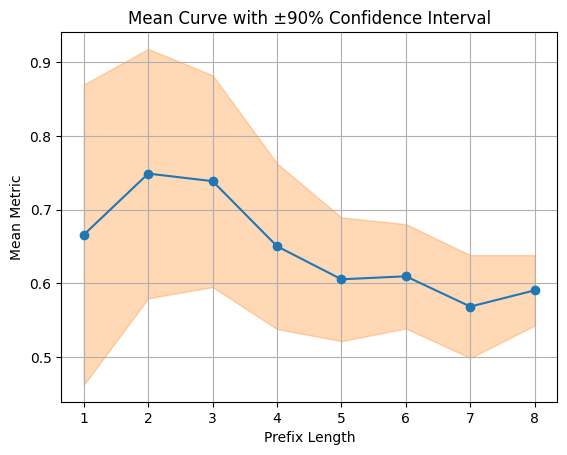

In [5]:
mean_samples_fitness_high_risk = seperate_dict_high_risk['mean_samples_fitness']
sd_samples_fitness_high_risk = seperate_dict_high_risk['sd_samples_fitness']

# Sort by prefix length
prefix = np.array(sorted(mean_samples_fitness_high_risk.keys()))
means  = np.array([np.mean(mean_samples_fitness_high_risk[k]) for k in prefix])
print("Means: ", means)

sds    = np.array([np.mean(sd_samples_fitness_high_risk[k]) for k in prefix])
print("SDs: ", sds)

uncertainties = np.array([sd/mean *100 for mean, sd in zip(means, sds)])
print("Uncertainties: ", uncertainties)

certainty = np.array([100-(sd/mean*100) for mean, sd in zip(means, sds)])
print("Certainties: ", certainty)

# 90% CI using z ≈ 1.645
z90 = 1.645

# Std within (fitness scores of T MC-Samples)-band: Probabilistic Suffix Prediction Fitness Score standard deviation:
lower_psp = means - z90 * sds
upper_psp = means + z90* sds


plt.figure()
plt.plot(prefix, means, marker='o', label='Mean Means Samples below Threshold', color='C0')
plt.fill_between(prefix, lower_psp, upper_psp, alpha=0.3, color='C1', label='Predictive Total Uncertainty')
plt.xlabel('Prefix Length')
plt.ylabel('Mean Metric')
plt.title('Mean Curve with ±90% Confidence Interval')
plt.grid(True)
plt.show()

In [6]:
target_conformance_high_risk = seperate_dict_high_risk['target_conformance']
most_likely_conformance_high_risk = seperate_dict_high_risk['most_likely_conformance']
# dict: prefix_length: list of list where mean fitness score smaller than threshold: 1000 MC samples with: 'sampled case', 'alignment', 'cost', 'fitness' 
samples_conformance_high_risk = seperate_dict_high_risk['samples_conformance']

In [7]:
dev_obj = Deviation()

In [8]:
# dict: pref_len, dict: model_moves: list of list, with tuples containing moves, log_moves: list of list, with tuples containing moves. 

deviations_target_high_risk = dev_obj.individual_deviations_target(target_conformance=target_conformance_high_risk)

deviations_most_likely_high_risk = dev_obj.individual_deviations_most_likely(most_likely_conformance=most_likely_conformance_high_risk)

deviations_samples_high_risk = dev_obj.individual_deviations_samples(samples_conformance=samples_conformance_high_risk,
                                                                beta_threshold=0.15)

deviations_samples_high_risk_prob = dev_obj.individual_deviations_samples(samples_conformance=samples_conformance_high_risk,
                                                                     beta_threshold=0.15,
                                                                     probabilistic=True)

In [9]:
eval_obj = EvaluationMetrics(target_alignments=deviations_target_high_risk,predicted_alignments=deviations_samples_high_risk)

In [10]:
#  Measures how often the model is correct when it predicts a deviation.
precision_dev, total_weighted_pref_len_precision = eval_obj.precision_deviation()

# This measures the model's ability to detect deviations when they actually occur. -> Models prediction in relation to deviations it does not predict
recall_dev, total_weighted_pref_len_recall = eval_obj.recall_deviation()


In [11]:
print("Precision Results:", precision_dev)
print("Total Weighted Prefix Length Precision: ", total_weighted_pref_len_precision)
print("Mean Precision Across Prefix Lengths: ", np.mean(list(precision_dev.values())))

print("\n")

print("Recall Results: ", recall_dev)
print("Total Weighted Prefix Length Recall: ", total_weighted_pref_len_recall)
print("Mean Recall Across Prefix Lengths: ", np.mean(list(recall_dev.values())))

Precision Results: OrderedDict({1: 0.29347826086956524, 2: 0.4367816091954023, 3: 0.5487804878048781, 4: 0.6666666666666666, 5: 0.8571428571428571, 6: 1.0, 7: 0.6666666666666666, 8: 0.6666666666666666})
Total Weighted Prefix Length Precision:  0.4815950920245399
Mean Precision Across Prefix Lengths:  0.6420229018765878


Recall Results:  OrderedDict({1: 0.43548387096774194, 2: 0.59375, 3: 0.7894736842105263, 4: 0.8235294117647058, 5: 0.8, 6: 1.0, 7: 0.6666666666666666, 8: 0.6666666666666666})
Total Weighted Prefix Length Recall:  0.6514522821576764
Mean Recall Across Prefix Lengths:  0.7219462875345384


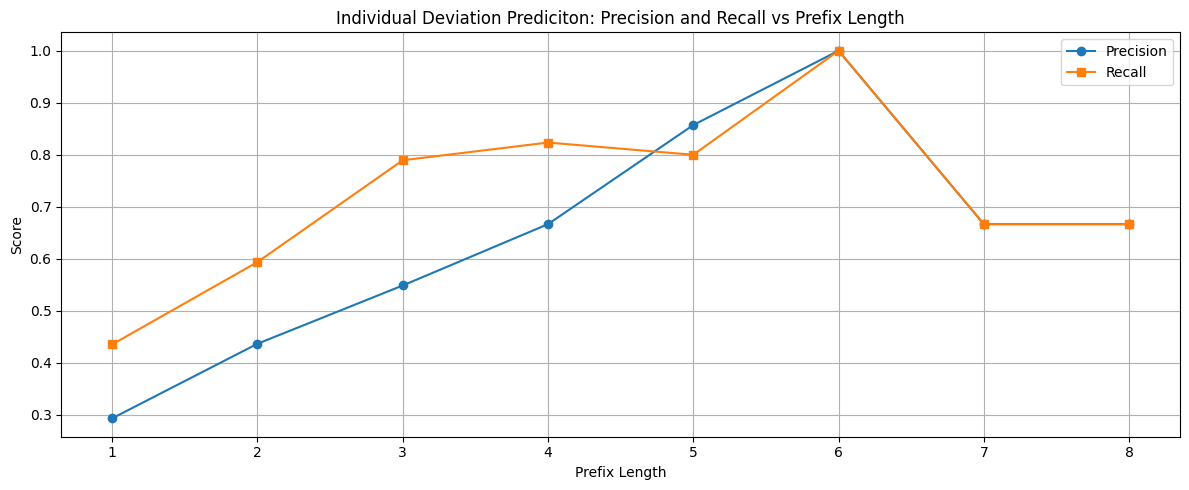

In [12]:
#
#

prefix = np.array(list(precision_dev.keys()))
prec = np.array(list(precision_dev.values()))
rec = np.array(list(recall_dev.values()))
idx = np.argsort(rec)

fig, (ax1) = plt.subplots(1, figsize=(12, 5))

# Precision vs Recall vs Prefix
ax1.plot(prefix, prec, marker='o')
ax1.plot(prefix, rec, marker='s')
ax1.set_xlabel('Prefix Length')
ax1.set_ylabel('Score')
ax1.set_title('Individual Deviation Prediciton: Precision and Recall vs Prefix Length')
ax1.legend(['Precision', 'Recall'])
ax1.grid(True)

plt.tight_layout()
plt.show()


Macro-avg AUC: 0.8090601853019461
Micro-avg AUC: 0.8075046581758536


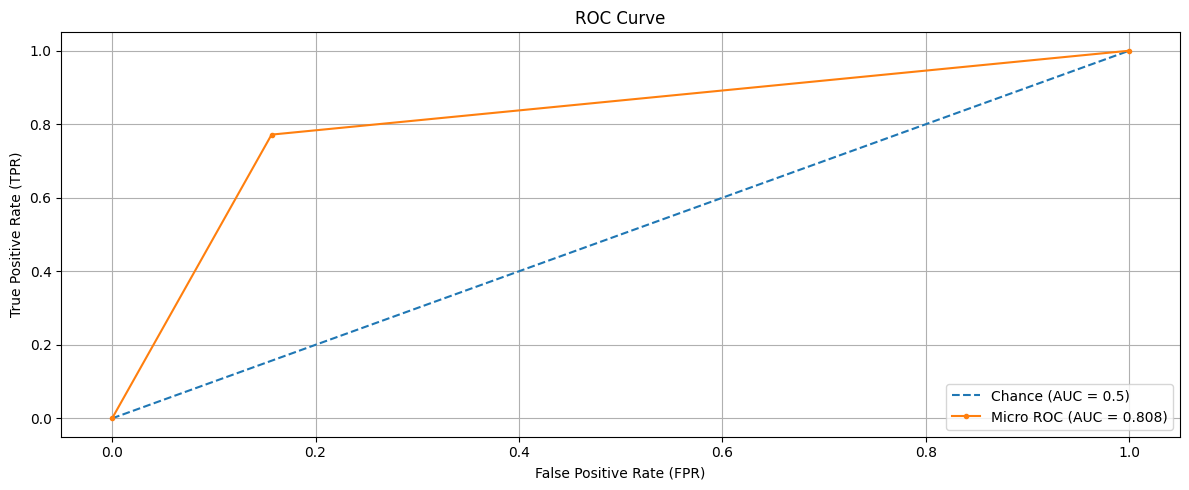

In [13]:
#
#

fpr_dict, tpr_dict, thr_dict, auc_macro, Y_true, Y_score = eval_obj.roc_deviation_multilabel('macro')
_,        _,         _,       auc_micro, _,      _       = eval_obj.roc_deviation_multilabel('micro')

print("Macro-avg AUC:", auc_macro)
print("Micro-avg AUC:", auc_micro)

# To plot e.g. the “micro” ROC curve as a single line:
fpr_micro, tpr_micro, _ = roc_curve(Y_true.ravel(), Y_score.ravel())

fig, (ax2) = plt.subplots(1, figsize=(12, 5))

# ROC Curves
ax2.plot([0, 1], [0, 1], linestyle='--', label='Chance (AUC = 0.5)')
# micro-averaged ROC
ax2.plot(fpr_micro, tpr_micro, marker='.', label=f'Micro ROC (AUC = {auc_micro:.3f})')

ax2.set_xlabel('False Positive Rate (FPR)')
ax2.set_ylabel('True Positive Rate (TPR)')
ax2.set_title('ROC Curve')
ax2.legend(loc='lower right')
ax2.grid(True)

plt.tight_layout()
plt.show()

Macro-avg AUC: 0.846230120542807
Micro-avg AUC: 0.854355917161138


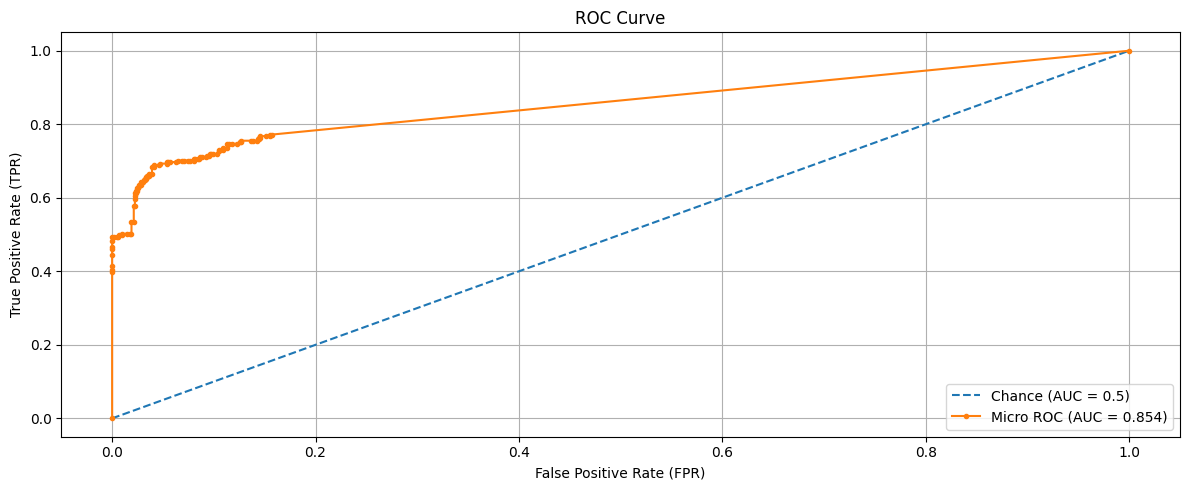

In [14]:
#
#

fpr_dict, tpr_dict, thr_dict, auc_macro, Y_true, Y_score = eval_obj.probabilistic_roc_deviation_multilabel(deviations_samples_risk=deviations_samples_high_risk_prob, average='macro')
_,        _,         _,       auc_micro, _,      _       = eval_obj.probabilistic_roc_deviation_multilabel(deviations_samples_risk=deviations_samples_high_risk_prob, average='micro')

print("Macro-avg AUC:", auc_macro)
print("Micro-avg AUC:", auc_micro)

# To plot e.g. the “micro” ROC curve as a single line:
fpr_micro, tpr_micro, _ = roc_curve(Y_true.ravel(), Y_score.ravel())

fig, (ax2) = plt.subplots(1, figsize=(12, 5))

# 2) ROC Curves
# chance line
ax2.plot([0, 1], [0, 1], linestyle='--', label='Chance (AUC = 0.5)')
# micro-averaged ROC
ax2.plot(fpr_micro, tpr_micro, marker='.', label=f'Micro ROC (AUC = {auc_micro:.3f})')

# ax2.plot(fpr_micro, tpr_micro, marker='.', label=f'Macro ROC (AUC = {auc_macro:.3f})')

ax2.set_xlabel('False Positive Rate (FPR)')
ax2.set_ylabel('True Positive Rate (TPR)')
ax2.set_title('ROC Curve')
ax2.legend(loc='lower right')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [15]:
filename = os.path.join(output_dir, 'all_inference_set.pkl')
with open(filename, 'rb') as f:
    loaded_results_all = pickle.load(f)
print(f"Loaded data from {filename}")

# grab the list of all metric‐names from the first entry
fields_all = list(loaded_results_all[next(iter(loaded_results_all))].keys())

# build the “pivoted” dict of dicts
seperate_dict_all = {field: { prefix: subdict[field] for prefix, subdict in loaded_results_all.items() } for field in fields_all}

Loaded data from ../../../../../../data/Helpdesk/conformal_prediction_gn_l4/all_inference_set.pkl


In [16]:
# Compute retention and discarded information rate:
# Here Retention rate should be approx: alpha:

# Retention rate: How many cases relatively to all cases are kept in the risk set.
cases_high_risk = np.sum([case_len for case_len in [len(case_ids) for case_ids in seperate_dict_high_risk['test_case_id'].values()]])

cases_all = np.sum([case_len for case_len in [len(case_ids) for case_ids in seperate_dict_all['test_case_id'].values()]])

retantion_rate = cases_high_risk / cases_all

print("High Risk Set contains", cases_high_risk, "cases.")

print("All Set contains", cases_all, "cases.")

print("Retantion Rate: High Risk Set contains", retantion_rate*100, "%", "of the cases, All Cases Set contains.")

High Risk Set contains 162 cases.
All Set contains 1946 cases.
Retantion Rate: High Risk Set contains 8.324768756423433 % of the cases, All Cases Set contains.
